In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier

# Data See

In [2]:
data = pd.read_csv('Предсказание осадков/train_data.csv')
test = pd.read_csv('Предсказание осадков/test_data.csv')

In [3]:
data.head()

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0       Brisbane     13.7     23.6       0.0          5.0       9.6   
1         Sydney     15.4     21.2      61.2          5.8       2.7   
2       Richmond     16.8     30.9       1.0          NaN       NaN   
3  NorfolkIsland     13.9     17.1       0.2          3.8       8.9   
4       Dartmoor      7.4     14.4       1.8          2.4       8.3   

  WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity9am  \
0         SSE           24.0        SSW        ESE  ...         65.0   
1           S           43.0        WSW        SSW  ...         91.0   
2          NE           35.0        NNW         NE  ...         80.0   
3          SE           37.0         SE        SSE  ...         56.0   
4         SSW           37.0        NaN         SW  ...        100.0   

   Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0         53.0       1028.4       1026.7       1.0       1.0     18.3   
1         65.0       1018.8       1016.5       8.0       7.0     15.6   
2         38.0       1020.4       1013.2       1.0       NaN     19.6   
3         63.0       1027.7       1026.1       3.0       1.0     15.3   
4         58.0       1026.0       1026.1       NaN       NaN      9.1   

   Temp3pm  RainToday  RainTomorrow  
0     22.3          0             0  
1     20.7          1             1  
2     30.0          0             0  
3     15.8          0             0  
4     13.5          1             0  

[5 rows x 22 columns]

In [4]:
# Проанализируем данные: видно, что есть пропущенные данные
# Пропущенные значения будем заменять на median

In [5]:
# Следующие колонки будут удалены, т. к. слишком много пропущенных значений:
# -----------------------
# Column         Not-Null
# -----------------------
# Evaporation    79262
# Sunshine       73028
# Cloud9am       84221
# Cloud3pm       81547

In [6]:
data[['Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']].describe()

Humidity3pm    Pressure9am    Pressure3pm      Cloud9am  \
count  131631.000000  121397.000000  121431.000000  84221.000000   
mean       51.568909    1017.665354    1015.268513      4.410111   
std        20.788435       7.098338       7.025179      2.884224   
min         0.000000     980.500000     977.100000      0.000000   
25%        37.000000    1013.000000    1010.500000      1.000000   
50%        52.000000    1017.700000    1015.300000      5.000000   
75%        66.000000    1022.400000    1020.000000      7.000000   
max       100.000000    1041.000000    1039.600000      9.000000   

           Cloud3pm        Temp9am        Temp3pm      RainToday  
count  81547.000000  133723.000000  132439.000000  135414.000000  
mean       4.495690      16.861988      21.532208       0.220302  
std        2.712436       6.471303       6.920364       0.414452  
min        0.000000      -7.200000      -5.400000       0.000000  
25%        2.000000      12.200000      16.500000       0.000000  
50%        5.000000      16.600000      20.900000       0.000000  
75%        7.000000      21.400000      26.200000       0.000000  
max        9.000000      40.200000      46.100000       1.000000

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135414 entries, 0 to 135413
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       135414 non-null  object 
 1   MinTemp        134061 non-null  float64
 2   MaxTemp        134260 non-null  float64
 3   Rainfall       132401 non-null  float64
 4   Evaporation    79262 non-null   float64
 5   Sunshine       73028 non-null   float64
 6   WindGustDir    125722 non-null  object 
 7   WindGustSpeed  125785 non-null  float64
 8   WindDir9am     125506 non-null  object 
 9   WindDir3pm     131665 non-null  object 
 10  WindSpeed9am   133719 non-null  float64
 11  WindSpeed3pm   132786 non-null  float64
 12  Humidity9am    132946 non-null  float64
 13  Humidity3pm    131631 non-null  float64
 14  Pressure9am    121397 non-null  float64
 15  Pressure3pm    121431 non-null  float64
 16  Cloud9am       84221 non-null   float64
 17  Cloud3pm       81547 non-null

In [8]:

for i in data.drop(['RainToday', 'RainTomorrow'], axis=1).columns:
    if data[i].dtypes != np.float_:
        data[i] = data[i].astype('category')

data.select_dtypes(include='category').describe()

Location WindGustDir WindDir9am WindDir3pm
count     135414      125722     125506     131665
unique        49          16         16         16
top     Canberra           W          N         SE
freq        3231        9376      11071      10053

In [9]:
data.dtypes

Location         category
MinTemp           float64
MaxTemp           float64
Rainfall          float64
Evaporation       float64
Sunshine          float64
WindGustDir      category
WindGustSpeed     float64
WindDir9am       category
WindDir3pm       category
WindSpeed9am      float64
WindSpeed3pm      float64
Humidity9am       float64
Humidity3pm       float64
Pressure9am       float64
Pressure3pm       float64
Cloud9am          float64
Cloud3pm          float64
Temp9am           float64
Temp3pm           float64
RainToday           int64
RainTomorrow        int64
dtype: object

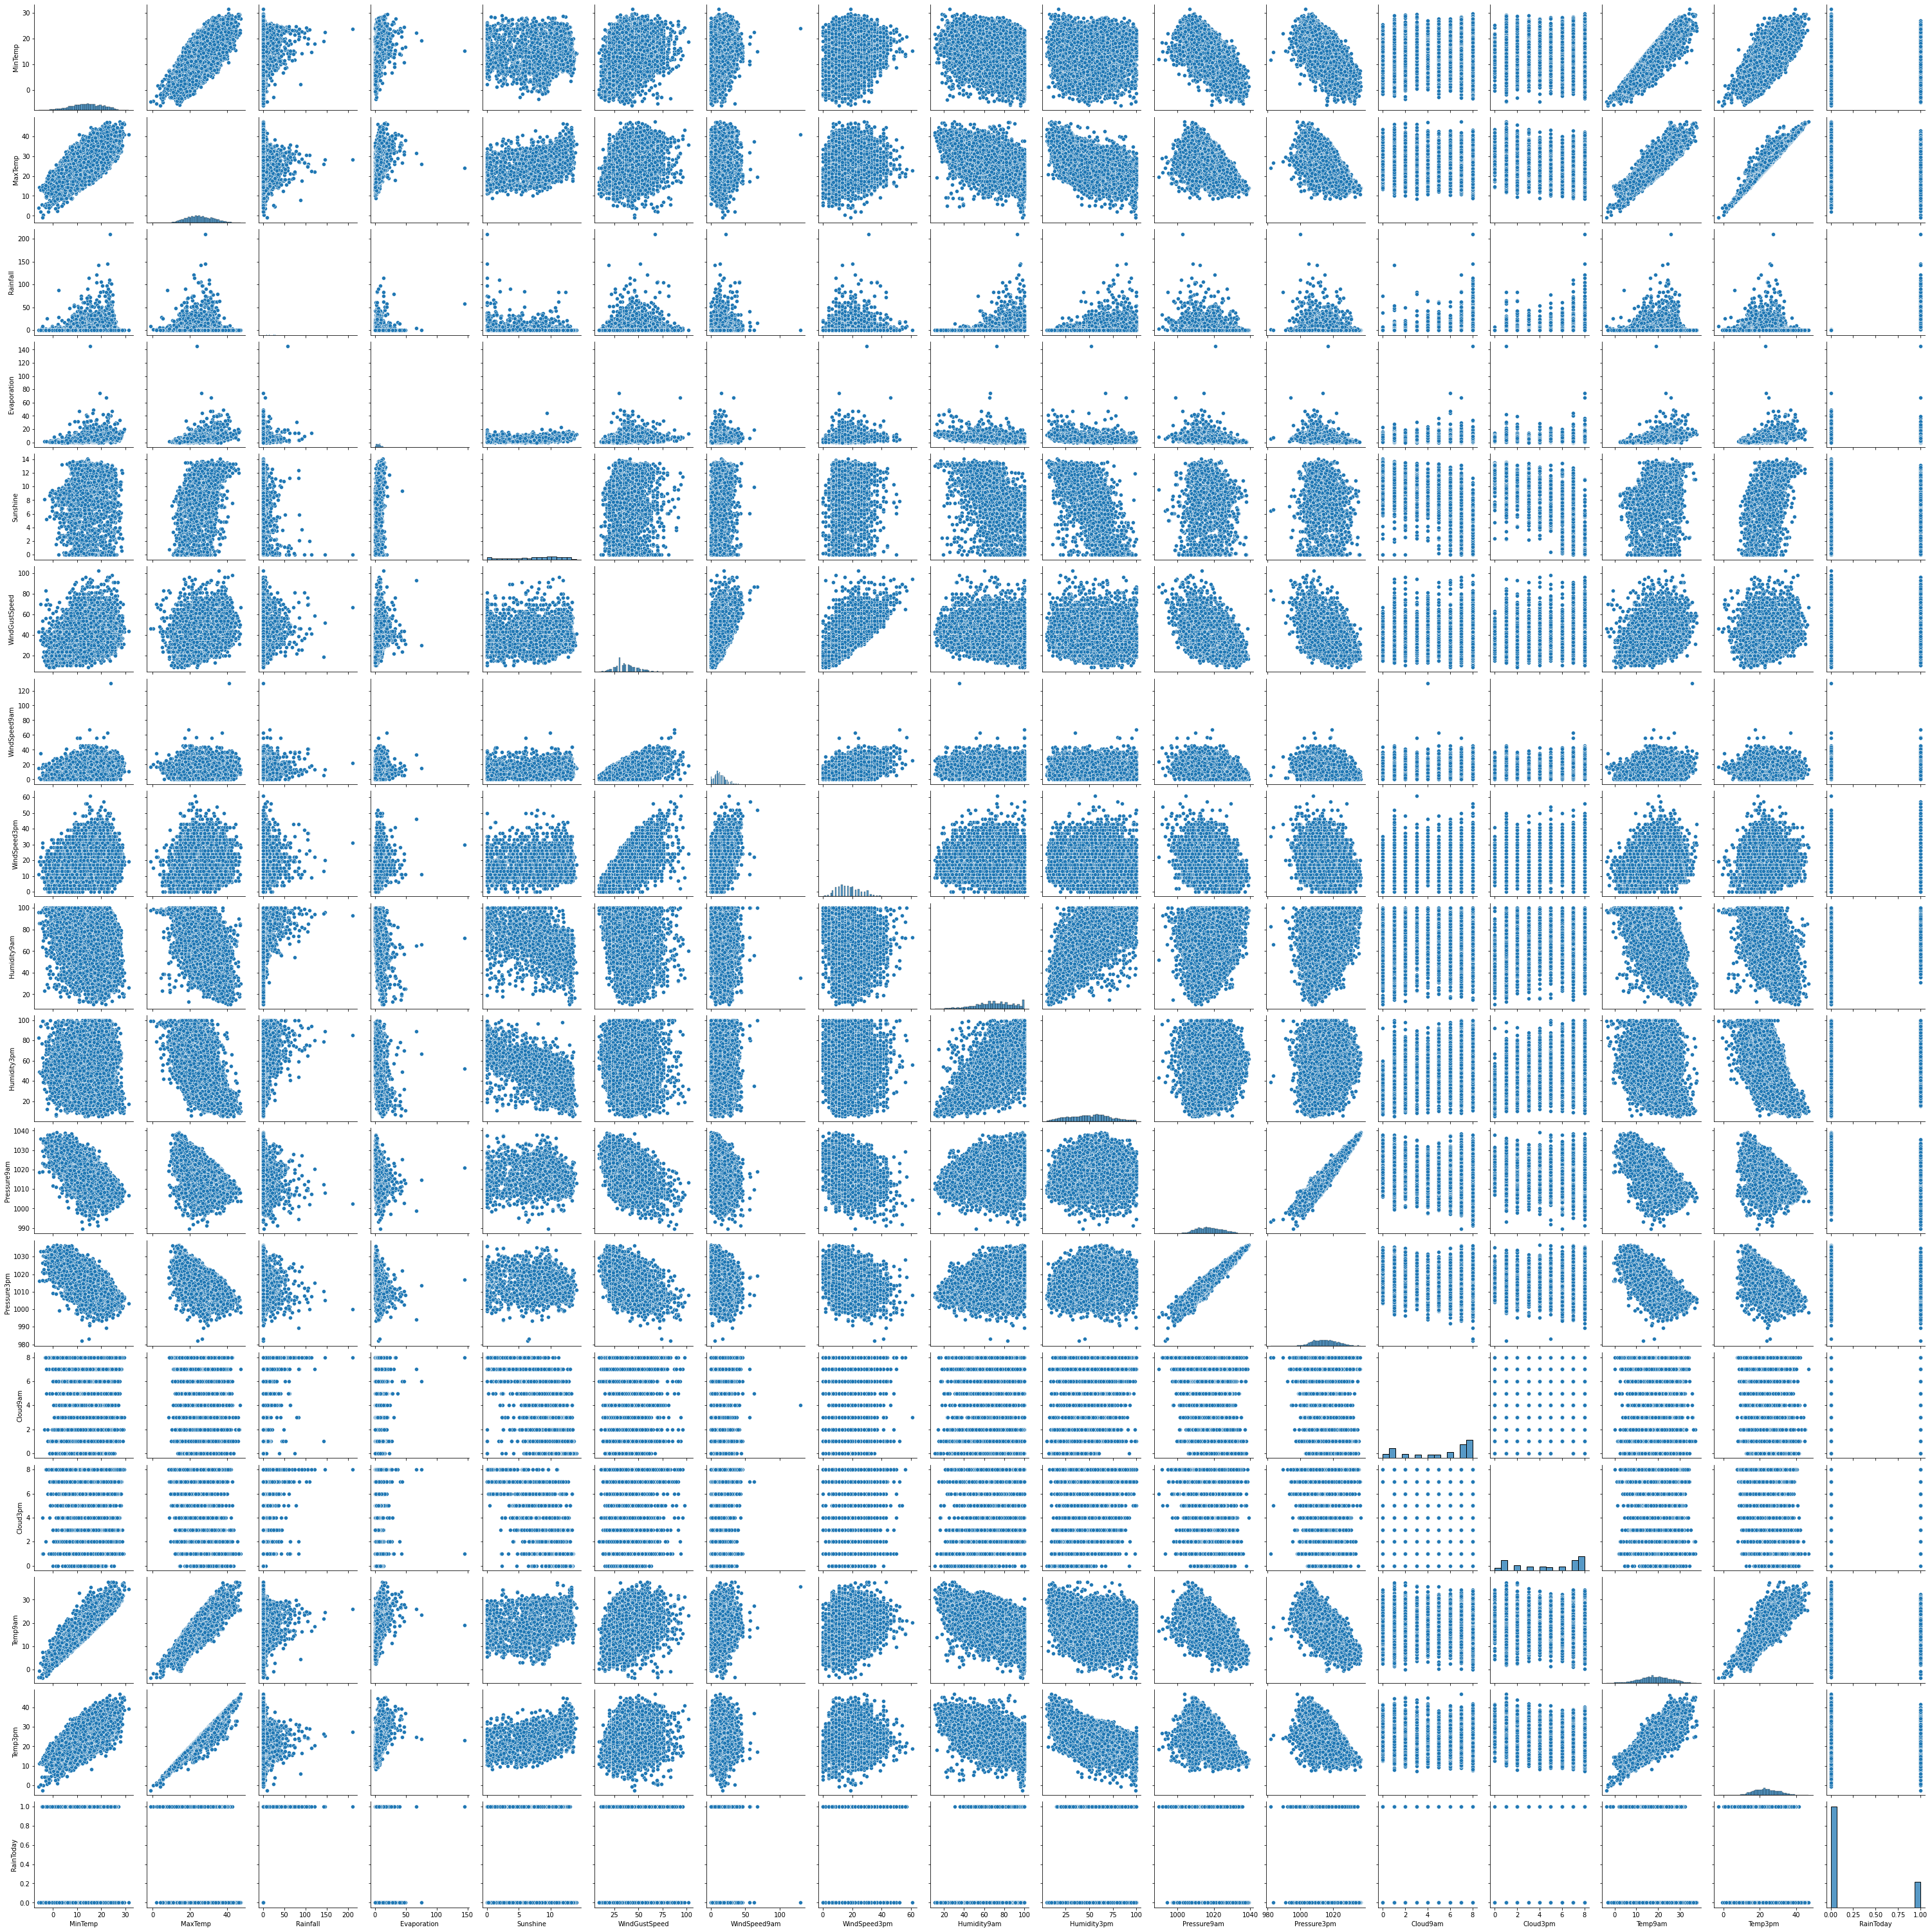

In [8]:
# По ошибке отобразил тестовые данные, но думаю картина такая же
sns.pairplot(data)

In [10]:
data['RainTomorrow'].value_counts()

0    105588
1     29826
Name: RainTomorrow, dtype: int64

In [ ]:
# В данных дисбаланс, бстинг говорят не боится этого

In [9]:
# В данных много кореллирующих фичей, данные не понять как распределны,
# скорее всего подойдут нелинейные методы, я ставлю на бустинг

In [12]:
# Также будет три варианта решения (так изначально планировалось):
# категориальные переменные - one-hot, 
# категориальные переменные - mean-target (реализовано в catboost), 
# без категориальные переменные

# pipeline make

In [71]:

# data.to_csv('Предсказание осадков/train.csv', na_rep=np.nan)
# d = pd.read_csv('Предсказание осадков/train.csv', na_values=np.nan)
# d[d['Evaporation'].isna()]


In [72]:
# d = data[data['MinTemp'].isna()].iloc[0, :].values
# pd.isnull(d)

In [88]:
data_for_learning = data.drop(['Evaporation', 'Sunshine','Cloud9am', 'Cloud3pm'], axis=1)

im_num = SimpleImputer(strategy='median').fit(data_for_learning[
    list(data_for_learning.select_dtypes(include='float').columns)
])

im_str = SimpleImputer(strategy='most_frequent').fit(data_for_learning[
    list(data_for_learning.select_dtypes(include='category').columns)
])

In [90]:
num_df = im_num.transform(data_for_learning.select_dtypes(include='float'))
num_df_col = data_for_learning.select_dtypes(include='float').columns
str_df = im_str.transform(data_for_learning.select_dtypes(include='category'))
str_df_col = data_for_learning.select_dtypes(include='category').columns
int_df = data_for_learning.select_dtypes(include='int')
int_df_col = data_for_learning.select_dtypes(include='int').columns

pd.concat([pd.DataFrame(num_df, columns=num_df_col), 
          pd.DataFrame(str_df, columns=str_df_col),
          pd.DataFrame(int_df, columns=int_df_col)], axis=1)

MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0          13.7     23.6       0.0           24.0           7.0           9.0   
1          15.4     21.2      61.2           43.0          19.0          24.0   
2          16.8     30.9       1.0           35.0           7.0          26.0   
3          13.9     17.1       0.2           37.0          17.0          20.0   
4           7.4     14.4       1.8           37.0           0.0          17.0   
...         ...      ...       ...            ...           ...           ...   
135409     17.6     25.1       0.0           56.0           9.0          19.0   
135410     15.1     25.2       0.0           48.0          11.0          28.0   
135411     10.5     18.4       1.2           50.0          15.0          13.0   
135412     13.6     19.8       2.6           54.0          11.0          20.0   
135413      6.9     15.9       0.2           20.0           9.0          11.0   

        Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm  \
0              65.0         53.0       1028.4       1026.7     18.3     22.3   
1              91.0         65.0       1018.8       1016.5     15.6     20.7   
2              80.0         38.0       1020.4       1013.2     19.6     30.0   
3              56.0         63.0       1027.7       1026.1     15.3     15.8   
4             100.0         58.0       1026.0       1026.1      9.1     13.5   
...             ...          ...          ...          ...      ...      ...   
135409         58.0         58.0       1012.8       1010.2     23.5     24.2   
135410         55.0         41.0       1018.8       1018.3     19.0     24.6   
135411         97.0         93.0       1017.7       1015.3     12.5     15.9   
135412         76.0         46.0       1008.5       1007.4     14.4     18.9   
135413         70.0         65.0       1029.7       1026.7     10.7     14.3   

             Location WindGustDir WindDir9am WindDir3pm  RainToday  \
0            Brisbane         SSE        SSW        ESE          0   
1              Sydney           S        WSW        SSW          1   
2            Richmond          NE        NNW         NE          0   
3       NorfolkIsland          SE         SE        SSE          0   
4            Dartmoor         SSW          N         SW          1   
...               ...         ...        ...        ...        ...   
135409      GoldCoast         SSE         SE          E          0   
135410       Adelaide          SW          S        WSW          0   
135411    MountGinini         SSE          E          E          1   
135412       Adelaide         WSW        WSW        WSW          1   
135413        Walpole           N          N          S          0   

        RainTomorrow  
0                  0  
1                  1  
2                  0  
3                  0  
4                  0  
...              ...  
135409             0  
135410             0  
135411             1  
135412             1  
135413             0  

[135414 rows x 18 columns]

In [195]:
def del_col(df, col_list):
    return df.drop(col_list, axis=1)

def impute_num(df):
    return SimpleImputer(strategy='median').fit(df[list(df.select_dtypes(include='float').columns)])

def impute_num_trans(im_num, df):
    df_n = df.select_dtypes(include='float')
    return im_num.transform(df_n), df_n.columns

def impute_str(df):
    return SimpleImputer(strategy='most_frequent').fit(df[list(df.select_dtypes(include='category').columns)])

def impute_str_trans(im_str, df):
    df_n = df.select_dtypes(include='category')
    return im_str.transform(df_n).copy(), df_n.columns

def select_int(df):
    df_n = df.select_dtypes(include='int')
    return df_n.copy(), df_n.columns

def concat(num_df, num_df_col, str_df, str_df_col, int_df, int_df_col):
    return pd.concat([pd.DataFrame(num_df, columns=num_df_col), 
          pd.DataFrame(str_df, columns=str_df_col),
            pd.DataFrame(int_df, columns=int_df_col)], axis=1)



In [213]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['RainTomorrow'], axis=1),\
                                                    data['RainTomorrow'], stratify=data['RainTomorrow'], random_state=0)


X_train = del_col(X_train, ['Evaporation', 'Sunshine','Cloud9am', 'Cloud3pm'])
X_test = del_col(X_test, ['Evaporation', 'Sunshine','Cloud9am', 'Cloud3pm'])

im_num = impute_num(X_train.copy())
X_train_num, num_col = impute_num_trans(im_num, X_train.copy())
X_test_num, num_col = impute_num_trans(im_num, X_test.copy())

im_str = impute_str(X_train.copy())
X_train_str, str_col = impute_str_trans(im_str, X_train.copy())
X_test_str, str_col = impute_str_trans(im_str, X_test.copy())

X_train_int, int_col = select_int(X_train.copy())
X_test_int, int_col = select_int(X_test.copy())

X_train = concat(X_train_num, num_col, X_train_str, str_col, X_train_int.values, int_col)
X_test = concat(X_test_num, num_col, X_test_str, str_col, X_test_int.values, int_col)

In [ ]:
# f1 - score

In [216]:
model = CatBoostClassifier(eval_metric='F1', cat_features=[16, 15, 14, 13, 12])
model.fit(X_train.values, y_train.values, eval_set=(X_test.values, y_test.values), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.099213
0:	learn: 0.5212954	test: 0.5241652	best: 0.5241652 (0)	total: 103ms	remaining: 1m 42s
1:	learn: 0.5442346	test: 0.5448356	best: 0.5448356 (1)	total: 137ms	remaining: 1m 8s
2:	learn: 0.5443478	test: 0.5464864	best: 0.5464864 (2)	total: 166ms	remaining: 55.1s
3:	learn: 0.5380668	test: 0.5403532	best: 0.5464864 (2)	total: 201ms	remaining: 50.1s
4:	learn: 0.5372223	test: 0.5358510	best: 0.5464864 (2)	total: 240ms	remaining: 47.8s
5:	learn: 0.5368900	test: 0.5391334	best: 0.5464864 (2)	total: 273ms	remaining: 45.2s
6:	learn: 0.5383898	test: 0.5407238	best: 0.5464864 (2)	total: 307ms	remaining: 43.6s
7:	learn: 0.5382699	test: 0.5397742	best: 0.5464864 (2)	total: 340ms	remaining: 42.1s
8:	learn: 0.5390866	test: 0.5387686	best: 0.5464864 (2)	total: 372ms	remaining: 40.9s
9:	learn: 0.5389391	test: 0.5408302	best: 0.5464864 (2)	total: 402ms	remaining: 39.8s
10:	learn: 0.5353336	test: 0.5386594	best: 0.5464864 (2)	total: 435ms	remaining: 39.2s
11:	learn: 0.5368760	t

96:	learn: 0.6026900	test: 0.6002565	best: 0.6002565 (96)	total: 3.71s	remaining: 34.5s
97:	learn: 0.6026678	test: 0.5999198	best: 0.6002565 (96)	total: 3.75s	remaining: 34.5s
98:	learn: 0.6026560	test: 0.6001283	best: 0.6002565 (96)	total: 3.79s	remaining: 34.5s
99:	learn: 0.6033900	test: 0.6003686	best: 0.6003686 (99)	total: 3.82s	remaining: 34.4s
100:	learn: 0.6039031	test: 0.6006088	best: 0.6006088 (100)	total: 3.87s	remaining: 34.5s
101:	learn: 0.6037940	test: 0.6007525	best: 0.6007525 (101)	total: 3.9s	remaining: 34.4s
102:	learn: 0.6039347	test: 0.6012486	best: 0.6012486 (102)	total: 3.95s	remaining: 34.4s
103:	learn: 0.6042500	test: 0.6010089	best: 0.6012486 (102)	total: 3.99s	remaining: 34.4s
104:	learn: 0.6043909	test: 0.6002243	best: 0.6012486 (102)	total: 4.02s	remaining: 34.3s
105:	learn: 0.6050711	test: 0.6009134	best: 0.6012486 (102)	total: 4.06s	remaining: 34.3s
106:	learn: 0.6055432	test: 0.6014893	best: 0.6014893 (106)	total: 4.1s	remaining: 34.2s
107:	learn: 0.605484

188:	learn: 0.6292948	test: 0.6178605	best: 0.6186494 (185)	total: 7.6s	remaining: 32.6s
189:	learn: 0.6296621	test: 0.6183453	best: 0.6186494 (185)	total: 7.65s	remaining: 32.6s
190:	learn: 0.6300795	test: 0.6184169	best: 0.6186494 (185)	total: 7.68s	remaining: 32.5s
191:	learn: 0.6303903	test: 0.6190364	best: 0.6190364 (191)	total: 7.72s	remaining: 32.5s
192:	learn: 0.6303568	test: 0.6190364	best: 0.6190364 (191)	total: 7.75s	remaining: 32.4s
193:	learn: 0.6306000	test: 0.6191565	best: 0.6191565 (193)	total: 7.79s	remaining: 32.4s
194:	learn: 0.6306617	test: 0.6193518	best: 0.6193518 (194)	total: 7.83s	remaining: 32.3s
195:	learn: 0.6307512	test: 0.6194383	best: 0.6194383 (195)	total: 7.87s	remaining: 32.3s
196:	learn: 0.6310450	test: 0.6194718	best: 0.6194718 (196)	total: 7.91s	remaining: 32.3s
197:	learn: 0.6314979	test: 0.6202332	best: 0.6202332 (197)	total: 7.95s	remaining: 32.2s
198:	learn: 0.6316013	test: 0.6200756	best: 0.6202332 (197)	total: 7.98s	remaining: 32.1s
199:	learn:

284:	learn: 0.6452225	test: 0.6286831	best: 0.6292504 (271)	total: 11.1s	remaining: 27.9s
285:	learn: 0.6454471	test: 0.6288394	best: 0.6292504 (271)	total: 11.2s	remaining: 27.9s
286:	learn: 0.6458042	test: 0.6289554	best: 0.6292504 (271)	total: 11.2s	remaining: 27.8s
287:	learn: 0.6461595	test: 0.6294416	best: 0.6294416 (287)	total: 11.2s	remaining: 27.8s
288:	learn: 0.6462277	test: 0.6295978	best: 0.6295978 (288)	total: 11.3s	remaining: 27.7s
289:	learn: 0.6462155	test: 0.6288346	best: 0.6295978 (288)	total: 11.3s	remaining: 27.7s
290:	learn: 0.6461968	test: 0.6294099	best: 0.6295978 (288)	total: 11.3s	remaining: 27.6s
291:	learn: 0.6463566	test: 0.6295486	best: 0.6295978 (288)	total: 11.4s	remaining: 27.6s
292:	learn: 0.6466760	test: 0.6294099	best: 0.6295978 (288)	total: 11.4s	remaining: 27.6s
293:	learn: 0.6466201	test: 0.6294591	best: 0.6295978 (288)	total: 11.5s	remaining: 27.5s
294:	learn: 0.6469550	test: 0.6297135	best: 0.6297135 (294)	total: 11.5s	remaining: 27.5s
295:	learn

379:	learn: 0.6566929	test: 0.6344763	best: 0.6344763 (378)	total: 14.6s	remaining: 23.9s
380:	learn: 0.6566396	test: 0.6345900	best: 0.6345900 (380)	total: 14.7s	remaining: 23.8s
381:	learn: 0.6565519	test: 0.6344270	best: 0.6345900 (380)	total: 14.7s	remaining: 23.8s
382:	learn: 0.6564994	test: 0.6344763	best: 0.6345900 (380)	total: 14.7s	remaining: 23.7s
383:	learn: 0.6563968	test: 0.6344838	best: 0.6345900 (380)	total: 14.8s	remaining: 23.7s
384:	learn: 0.6564821	test: 0.6345332	best: 0.6345900 (380)	total: 14.8s	remaining: 23.7s
385:	learn: 0.6565707	test: 0.6342070	best: 0.6345900 (380)	total: 14.8s	remaining: 23.6s
386:	learn: 0.6569247	test: 0.6342639	best: 0.6345900 (380)	total: 14.9s	remaining: 23.6s
387:	learn: 0.6570124	test: 0.6337973	best: 0.6345900 (380)	total: 14.9s	remaining: 23.5s
388:	learn: 0.6574531	test: 0.6346468	best: 0.6346468 (388)	total: 15s	remaining: 23.5s
389:	learn: 0.6575235	test: 0.6349157	best: 0.6349157 (389)	total: 15s	remaining: 23.5s
390:	learn: 0.

474:	learn: 0.6675732	test: 0.6365398	best: 0.6379284 (455)	total: 18.1s	remaining: 20s
475:	learn: 0.6676777	test: 0.6365822	best: 0.6379284 (455)	total: 18.2s	remaining: 20s
476:	learn: 0.6679389	test: 0.6364764	best: 0.6379284 (455)	total: 18.2s	remaining: 20s
477:	learn: 0.6680957	test: 0.6369061	best: 0.6379284 (455)	total: 18.2s	remaining: 19.9s
478:	learn: 0.6680261	test: 0.6368499	best: 0.6379284 (455)	total: 18.3s	remaining: 19.9s
479:	learn: 0.6682702	test: 0.6368992	best: 0.6379284 (455)	total: 18.3s	remaining: 19.8s
480:	learn: 0.6684447	test: 0.6367018	best: 0.6379284 (455)	total: 18.3s	remaining: 19.8s
481:	learn: 0.6683576	test: 0.6367018	best: 0.6379284 (455)	total: 18.4s	remaining: 19.7s
482:	learn: 0.6684619	test: 0.6368005	best: 0.6379284 (455)	total: 18.4s	remaining: 19.7s
483:	learn: 0.6683228	test: 0.6368992	best: 0.6379284 (455)	total: 18.4s	remaining: 19.7s
484:	learn: 0.6684969	test: 0.6368992	best: 0.6379284 (455)	total: 18.5s	remaining: 19.6s
485:	learn: 0.66

569:	learn: 0.6766109	test: 0.6401052	best: 0.6406806 (565)	total: 21.6s	remaining: 16.3s
570:	learn: 0.6767305	test: 0.6404764	best: 0.6406806 (565)	total: 21.7s	remaining: 16.3s
571:	learn: 0.6769215	test: 0.6404268	best: 0.6406806 (565)	total: 21.7s	remaining: 16.3s
572:	learn: 0.6771124	test: 0.6404764	best: 0.6406806 (565)	total: 21.8s	remaining: 16.2s
573:	learn: 0.6771612	test: 0.6408968	best: 0.6408968 (573)	total: 21.8s	remaining: 16.2s
574:	learn: 0.6770057	test: 0.6407422	best: 0.6408968 (573)	total: 21.8s	remaining: 16.1s
575:	learn: 0.6769375	test: 0.6407917	best: 0.6408968 (573)	total: 21.9s	remaining: 16.1s
576:	learn: 0.6771268	test: 0.6405380	best: 0.6408968 (573)	total: 21.9s	remaining: 16.1s
577:	learn: 0.6771116	test: 0.6404329	best: 0.6408968 (573)	total: 21.9s	remaining: 16s
578:	learn: 0.6773529	test: 0.6404946	best: 0.6408968 (573)	total: 22s	remaining: 16s
579:	learn: 0.6775102	test: 0.6405501	best: 0.6408968 (573)	total: 22s	remaining: 15.9s
580:	learn: 0.6776

664:	learn: 0.6855894	test: 0.6417599	best: 0.6423279 (635)	total: 25.1s	remaining: 12.6s
665:	learn: 0.6857604	test: 0.6417046	best: 0.6423279 (635)	total: 25.1s	remaining: 12.6s
666:	learn: 0.6860235	test: 0.6416609	best: 0.6423279 (635)	total: 25.2s	remaining: 12.6s
667:	learn: 0.6861037	test: 0.6421353	best: 0.6423279 (635)	total: 25.2s	remaining: 12.5s
668:	learn: 0.6858451	test: 0.6417715	best: 0.6423279 (635)	total: 25.3s	remaining: 12.5s
669:	learn: 0.6858139	test: 0.6420801	best: 0.6423279 (635)	total: 25.3s	remaining: 12.5s
670:	learn: 0.6857604	test: 0.6419753	best: 0.6423279 (635)	total: 25.3s	remaining: 12.4s
671:	learn: 0.6860353	test: 0.6419258	best: 0.6423279 (635)	total: 25.4s	remaining: 12.4s
672:	learn: 0.6860873	test: 0.6420306	best: 0.6423279 (635)	total: 25.4s	remaining: 12.4s
673:	learn: 0.6861557	test: 0.6419696	best: 0.6423279 (635)	total: 25.5s	remaining: 12.3s
674:	learn: 0.6861037	test: 0.6420744	best: 0.6423279 (635)	total: 25.5s	remaining: 12.3s
675:	learn

759:	learn: 0.6926052	test: 0.6418877	best: 0.6427856 (746)	total: 28.6s	remaining: 9.04s
760:	learn: 0.6926751	test: 0.6423009	best: 0.6427856 (746)	total: 28.7s	remaining: 9s
761:	learn: 0.6928128	test: 0.6421962	best: 0.6427856 (746)	total: 28.7s	remaining: 8.96s
762:	learn: 0.6925933	test: 0.6422457	best: 0.6427856 (746)	total: 28.7s	remaining: 8.93s
763:	learn: 0.6926492	test: 0.6424663	best: 0.6427856 (746)	total: 28.8s	remaining: 8.89s
764:	learn: 0.6927351	test: 0.6425765	best: 0.6427856 (746)	total: 28.8s	remaining: 8.85s
765:	learn: 0.6928868	test: 0.6424719	best: 0.6427856 (746)	total: 28.9s	remaining: 8.81s
766:	learn: 0.6927531	test: 0.6421028	best: 0.6427856 (746)	total: 28.9s	remaining: 8.78s
767:	learn: 0.6929089	test: 0.6422075	best: 0.6427856 (746)	total: 28.9s	remaining: 8.74s
768:	learn: 0.6928091	test: 0.6422570	best: 0.6427856 (746)	total: 29s	remaining: 8.7s
769:	learn: 0.6927212	test: 0.6426644	best: 0.6427856 (746)	total: 29s	remaining: 8.66s
770:	learn: 0.6928

853:	learn: 0.6997177	test: 0.6427474	best: 0.6440261 (841)	total: 32.1s	remaining: 5.49s
854:	learn: 0.6995959	test: 0.6431589	best: 0.6440261 (841)	total: 32.2s	remaining: 5.46s
855:	learn: 0.6996271	test: 0.6429010	best: 0.6440261 (841)	total: 32.2s	remaining: 5.42s
856:	learn: 0.6996633	test: 0.6429614	best: 0.6440261 (841)	total: 32.3s	remaining: 5.38s
857:	learn: 0.6997954	test: 0.6431644	best: 0.6440261 (841)	total: 32.3s	remaining: 5.35s
858:	learn: 0.6998187	test: 0.6432138	best: 0.6440261 (841)	total: 32.3s	remaining: 5.31s
859:	learn: 0.6997850	test: 0.6430108	best: 0.6440261 (841)	total: 32.4s	remaining: 5.27s
860:	learn: 0.6998342	test: 0.6431150	best: 0.6440261 (841)	total: 32.4s	remaining: 5.23s
861:	learn: 0.7000388	test: 0.6432686	best: 0.6440261 (841)	total: 32.5s	remaining: 5.2s
862:	learn: 0.7001864	test: 0.6431150	best: 0.6440261 (841)	total: 32.5s	remaining: 5.16s
863:	learn: 0.7004635	test: 0.6430108	best: 0.6440261 (841)	total: 32.5s	remaining: 5.12s
864:	learn:

947:	learn: 0.7058093	test: 0.6429557	best: 0.6440261 (841)	total: 35.7s	remaining: 1.96s
948:	learn: 0.7059189	test: 0.6431583	best: 0.6440261 (841)	total: 35.7s	remaining: 1.92s
949:	learn: 0.7061808	test: 0.6432623	best: 0.6440261 (841)	total: 35.8s	remaining: 1.88s
950:	learn: 0.7063786	test: 0.6433609	best: 0.6440261 (841)	total: 35.8s	remaining: 1.84s
951:	learn: 0.7063420	test: 0.6432076	best: 0.6440261 (841)	total: 35.9s	remaining: 1.81s
952:	learn: 0.7061107	test: 0.6434103	best: 0.6440261 (841)	total: 35.9s	remaining: 1.77s
953:	learn: 0.7062720	test: 0.6433609	best: 0.6440261 (841)	total: 35.9s	remaining: 1.73s
954:	learn: 0.7062354	test: 0.6436182	best: 0.6440261 (841)	total: 36s	remaining: 1.69s
955:	learn: 0.7060833	test: 0.6434156	best: 0.6440261 (841)	total: 36s	remaining: 1.66s
956:	learn: 0.7062172	test: 0.6432076	best: 0.6440261 (841)	total: 36s	remaining: 1.62s
957:	learn: 0.7062932	test: 0.6429448	best: 0.6440261 (841)	total: 36.1s	remaining: 1.58s
958:	learn: 0.70

# Prediction

In [218]:
min(10, 15 * f1_score(model.predict(X_test.values), y_test.values))

9.660391855551286

In [250]:
data = pd.read_csv('Предсказание осадков/train_data.csv')

for i in data.drop(['RainTomorrow'], axis=1).columns:
    if data[i].dtypes != np.float_:
        data[i] = data[i].astype('category')

data.select_dtypes(include='category').describe()

Location WindGustDir WindDir9am WindDir3pm  RainToday
count     135414      125722     125506     131665     135414
unique        49          16         16         16          2
top     Canberra           W          N         SE          0
freq        3231        9376      11071      10053     105582

In [251]:
def del_col(df, col_list):
    return df.drop(col_list, axis=1)

def impute_num(df):
    return SimpleImputer(strategy='median').fit(df[list(df.select_dtypes(include='float').columns)])

def impute_num_trans(im_num, df):
    df_n = df.select_dtypes(include='float')
    return im_num.transform(df_n), df_n.columns

def impute_str(df):
    return SimpleImputer(strategy='most_frequent').fit(df[list(df.select_dtypes(include='category').columns)])

def impute_str_trans(im_str, df):
    df_n = df.select_dtypes(include='category')
    return im_str.transform(df_n).copy(), df_n.columns


def concat(num_df, num_df_col, str_df, str_df_col):
    return pd.concat([pd.DataFrame(num_df, columns=num_df_col), 
          pd.DataFrame(str_df, columns=str_df_col)], axis=1)



In [252]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['RainTomorrow'], axis=1),\
                                                    data['RainTomorrow'], stratify=data['RainTomorrow'],\
                                                    random_state=0, test_size=0.1)


X_train = del_col(X_train, ['Evaporation', 'Sunshine','Cloud9am', 'Cloud3pm'])
X_test = del_col(X_test, ['Evaporation', 'Sunshine','Cloud9am', 'Cloud3pm'])

im_num = impute_num(X_train.copy())
X_train_num, num_col = impute_num_trans(im_num, X_train.copy())
X_test_num, num_col = impute_num_trans(im_num, X_test.copy())

im_str = impute_str(X_train.copy())
X_train_str, str_col = impute_str_trans(im_str, X_train.copy())
X_test_str, str_col = impute_str_trans(im_str, X_test.copy())


X_train = concat(X_train_num, num_col, X_train_str, str_col)
X_test = concat(X_test_num, num_col, X_test_str, str_col)

In [253]:
y_train.value_counts(), len(y_train)

(0    95029
 1    26843
 Name: RainTomorrow, dtype: int64,
 121872)

In [254]:
y_test.value_counts(), len(y_test)

(0    10559
 1     2983
 Name: RainTomorrow, dtype: int64,
 13542)

In [258]:
model = CatBoostClassifier(eval_metric='F1', cat_features=[16, 15, 14, 13, 12], auto_class_weights='Balanced')
model.fit(X_train.values, y_train.values, eval_set=(X_test.values, y_test.values), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.103783
0:	learn: 0.7312281	test: 0.7286530	best: 0.7286530 (0)	total: 48.3ms	remaining: 48.2s
1:	learn: 0.7369623	test: 0.7334839	best: 0.7334839 (1)	total: 89.8ms	remaining: 44.8s
2:	learn: 0.7427419	test: 0.7392966	best: 0.7392966 (2)	total: 127ms	remaining: 42.3s
3:	learn: 0.7508795	test: 0.7473839	best: 0.7473839 (3)	total: 169ms	remaining: 42.2s
4:	learn: 0.7520631	test: 0.7506713	best: 0.7506713 (4)	total: 208ms	remaining: 41.4s
5:	learn: 0.7528190	test: 0.7508620	best: 0.7508620 (5)	total: 249ms	remaining: 41.3s
6:	learn: 0.7549388	test: 0.7507245	best: 0.7508620 (5)	total: 295ms	remaining: 41.8s
7:	learn: 0.7550929	test: 0.7511956	best: 0.7511956 (7)	total: 327ms	remaining: 40.6s
8:	learn: 0.7554035	test: 0.7533471	best: 0.7533471 (8)	total: 370ms	remaining: 40.7s
9:	learn: 0.7562361	test: 0.7544351	best: 0.7544351 (9)	total: 403ms	remaining: 39.9s
10:	learn: 0.7562836	test: 0.7524253	best: 0.7544351 (9)	total: 448ms	remaining: 40.3s
11:	learn: 0.7567889	

95:	learn: 0.7936367	test: 0.7890788	best: 0.7892100 (94)	total: 4.13s	remaining: 38.9s
96:	learn: 0.7939736	test: 0.7888661	best: 0.7892100 (94)	total: 4.18s	remaining: 38.9s
97:	learn: 0.7944951	test: 0.7888993	best: 0.7892100 (94)	total: 4.24s	remaining: 39s
98:	learn: 0.7942145	test: 0.7886537	best: 0.7892100 (94)	total: 4.28s	remaining: 39s
99:	learn: 0.7946090	test: 0.7888230	best: 0.7892100 (94)	total: 4.32s	remaining: 38.9s
100:	learn: 0.7947753	test: 0.7883912	best: 0.7892100 (94)	total: 4.36s	remaining: 38.8s
101:	learn: 0.7950579	test: 0.7885271	best: 0.7892100 (94)	total: 4.41s	remaining: 38.8s
102:	learn: 0.7951030	test: 0.7894340	best: 0.7894340 (102)	total: 4.45s	remaining: 38.8s
103:	learn: 0.7950988	test: 0.7893740	best: 0.7894340 (102)	total: 4.49s	remaining: 38.7s
104:	learn: 0.7954754	test: 0.7900501	best: 0.7900501 (104)	total: 4.54s	remaining: 38.7s
105:	learn: 0.7955772	test: 0.7898430	best: 0.7900501 (104)	total: 4.58s	remaining: 38.7s
106:	learn: 0.7955918	test

191:	learn: 0.8073233	test: 0.7967262	best: 0.7967262 (191)	total: 8.49s	remaining: 35.8s
192:	learn: 0.8074731	test: 0.7967646	best: 0.7967646 (192)	total: 8.55s	remaining: 35.7s
193:	learn: 0.8076463	test: 0.7966109	best: 0.7967646 (192)	total: 8.59s	remaining: 35.7s
194:	learn: 0.8077417	test: 0.7964822	best: 0.7967646 (192)	total: 8.63s	remaining: 35.6s
195:	learn: 0.8079030	test: 0.7962516	best: 0.7967646 (192)	total: 8.67s	remaining: 35.6s
196:	learn: 0.8080947	test: 0.7956483	best: 0.7967646 (192)	total: 8.71s	remaining: 35.5s
197:	learn: 0.8085305	test: 0.7955577	best: 0.7967646 (192)	total: 8.76s	remaining: 35.5s
198:	learn: 0.8083131	test: 0.7957882	best: 0.7967646 (192)	total: 8.81s	remaining: 35.5s
199:	learn: 0.8085053	test: 0.7959171	best: 0.7967646 (192)	total: 8.85s	remaining: 35.4s
200:	learn: 0.8085958	test: 0.7958650	best: 0.7967646 (192)	total: 8.89s	remaining: 35.3s
201:	learn: 0.8085267	test: 0.7958266	best: 0.7967646 (192)	total: 8.93s	remaining: 35.3s
202:	learn

286:	learn: 0.8156030	test: 0.7997460	best: 0.7997460 (286)	total: 12.6s	remaining: 31.4s
287:	learn: 0.8156924	test: 0.7993858	best: 0.7997460 (286)	total: 12.7s	remaining: 31.4s
288:	learn: 0.8157072	test: 0.7995405	best: 0.7997460 (286)	total: 12.7s	remaining: 31.3s
289:	learn: 0.8157380	test: 0.7996565	best: 0.7997460 (286)	total: 12.8s	remaining: 31.3s
290:	learn: 0.8158207	test: 0.7994896	best: 0.7997460 (286)	total: 12.8s	remaining: 31.2s
291:	learn: 0.8160371	test: 0.7997725	best: 0.7997725 (291)	total: 12.8s	remaining: 31.1s
292:	learn: 0.8159354	test: 0.7996565	best: 0.7997725 (291)	total: 12.9s	remaining: 31.1s
293:	learn: 0.8161642	test: 0.7989885	best: 0.7997725 (291)	total: 12.9s	remaining: 31.1s
294:	learn: 0.8163454	test: 0.7992716	best: 0.7997725 (291)	total: 13s	remaining: 31s
295:	learn: 0.8162258	test: 0.7989498	best: 0.7997725 (291)	total: 13s	remaining: 31s
296:	learn: 0.8163128	test: 0.7994000	best: 0.7997725 (291)	total: 13.1s	remaining: 30.9s
297:	learn: 0.8164

378:	learn: 0.8211091	test: 0.8008302	best: 0.8011364 (370)	total: 16.6s	remaining: 27.2s
379:	learn: 0.8211311	test: 0.8004577	best: 0.8011364 (370)	total: 16.6s	remaining: 27.1s
380:	learn: 0.8212278	test: 0.8004965	best: 0.8011364 (370)	total: 16.7s	remaining: 27.1s
381:	learn: 0.8214088	test: 0.8009465	best: 0.8011364 (370)	total: 16.7s	remaining: 27s
382:	learn: 0.8214132	test: 0.8015241	best: 0.8015241 (382)	total: 16.7s	remaining: 27s
383:	learn: 0.8214393	test: 0.8015241	best: 0.8015241 (382)	total: 16.8s	remaining: 26.9s
384:	learn: 0.8214964	test: 0.8014465	best: 0.8015241 (382)	total: 16.8s	remaining: 26.9s
385:	learn: 0.8214439	test: 0.8012024	best: 0.8015241 (382)	total: 16.9s	remaining: 26.8s
386:	learn: 0.8215978	test: 0.8009194	best: 0.8015241 (382)	total: 16.9s	remaining: 26.8s
387:	learn: 0.8214787	test: 0.8014465	best: 0.8015241 (382)	total: 17s	remaining: 26.7s
388:	learn: 0.8215660	test: 0.8016906	best: 0.8016906 (388)	total: 17s	remaining: 26.7s
389:	learn: 0.8217

472:	learn: 0.8269568	test: 0.8024504	best: 0.8032209 (461)	total: 20.7s	remaining: 23s
473:	learn: 0.8269304	test: 0.8024115	best: 0.8032209 (461)	total: 20.7s	remaining: 23s
474:	learn: 0.8269084	test: 0.8028994	best: 0.8032209 (461)	total: 20.7s	remaining: 22.9s
475:	learn: 0.8269872	test: 0.8027829	best: 0.8032209 (461)	total: 20.8s	remaining: 22.9s
476:	learn: 0.8268730	test: 0.8035530	best: 0.8035530 (476)	total: 20.8s	remaining: 22.8s
477:	learn: 0.8269696	test: 0.8036412	best: 0.8036412 (477)	total: 20.9s	remaining: 22.8s
478:	learn: 0.8273689	test: 0.8030763	best: 0.8036412 (477)	total: 20.9s	remaining: 22.7s
479:	learn: 0.8272637	test: 0.8028714	best: 0.8036412 (477)	total: 21s	remaining: 22.7s
480:	learn: 0.8273164	test: 0.8032316	best: 0.8036412 (477)	total: 21s	remaining: 22.7s
481:	learn: 0.8273470	test: 0.8030159	best: 0.8036412 (477)	total: 21.1s	remaining: 22.6s
482:	learn: 0.8274742	test: 0.8032598	best: 0.8036412 (477)	total: 21.1s	remaining: 22.6s
483:	learn: 0.8276

567:	learn: 0.8321758	test: 0.8052958	best: 0.8055882 (564)	total: 24.8s	remaining: 18.9s
568:	learn: 0.8321405	test: 0.8049742	best: 0.8055882 (564)	total: 24.9s	remaining: 18.8s
569:	learn: 0.8321583	test: 0.8046915	best: 0.8055882 (564)	total: 24.9s	remaining: 18.8s
570:	learn: 0.8323506	test: 0.8046525	best: 0.8055882 (564)	total: 24.9s	remaining: 18.7s
571:	learn: 0.8323767	test: 0.8053446	best: 0.8055882 (564)	total: 25s	remaining: 18.7s
572:	learn: 0.8324426	test: 0.8052179	best: 0.8055882 (564)	total: 25s	remaining: 18.7s
573:	learn: 0.8324600	test: 0.8051400	best: 0.8055882 (564)	total: 25.1s	remaining: 18.6s
574:	learn: 0.8325826	test: 0.8057927	best: 0.8057927 (574)	total: 25.1s	remaining: 18.6s
575:	learn: 0.8325653	test: 0.8059581	best: 0.8059581 (575)	total: 25.2s	remaining: 18.5s
576:	learn: 0.8325741	test: 0.8059581	best: 0.8059581 (575)	total: 25.2s	remaining: 18.5s
577:	learn: 0.8326918	test: 0.8059971	best: 0.8059971 (577)	total: 25.2s	remaining: 18.4s
578:	learn: 0.

662:	learn: 0.8365148	test: 0.8068257	best: 0.8068922 (618)	total: 29s	remaining: 14.8s
663:	learn: 0.8365498	test: 0.8069037	best: 0.8069037 (663)	total: 29.1s	remaining: 14.7s
664:	learn: 0.8366757	test: 0.8069037	best: 0.8069037 (663)	total: 29.2s	remaining: 14.7s
665:	learn: 0.8366068	test: 0.8069037	best: 0.8069037 (663)	total: 29.2s	remaining: 14.6s
666:	learn: 0.8367150	test: 0.8069428	best: 0.8069428 (666)	total: 29.2s	remaining: 14.6s
667:	learn: 0.8367849	test: 0.8069129	best: 0.8069428 (666)	total: 29.3s	remaining: 14.6s
668:	learn: 0.8368375	test: 0.8065432	best: 0.8069428 (666)	total: 29.3s	remaining: 14.5s
669:	learn: 0.8367683	test: 0.8071472	best: 0.8071472 (669)	total: 29.4s	remaining: 14.5s
670:	learn: 0.8370907	test: 0.8066212	best: 0.8071472 (669)	total: 29.4s	remaining: 14.4s
671:	learn: 0.8370693	test: 0.8065822	best: 0.8071472 (669)	total: 29.5s	remaining: 14.4s
672:	learn: 0.8370782	test: 0.8066212	best: 0.8071472 (669)	total: 29.5s	remaining: 14.3s
673:	learn: 

756:	learn: 0.8399899	test: 0.8061743	best: 0.8074686 (684)	total: 33.3s	remaining: 10.7s
757:	learn: 0.8400155	test: 0.8062134	best: 0.8074686 (684)	total: 33.3s	remaining: 10.6s
758:	learn: 0.8400598	test: 0.8065748	best: 0.8074686 (684)	total: 33.4s	remaining: 10.6s
759:	learn: 0.8399983	test: 0.8063698	best: 0.8074686 (684)	total: 33.4s	remaining: 10.6s
760:	learn: 0.8400185	test: 0.8067405	best: 0.8074686 (684)	total: 33.5s	remaining: 10.5s
761:	learn: 0.8400066	test: 0.8067405	best: 0.8074686 (684)	total: 33.5s	remaining: 10.5s
762:	learn: 0.8398541	test: 0.8065356	best: 0.8074686 (684)	total: 33.6s	remaining: 10.4s
763:	learn: 0.8400573	test: 0.8065748	best: 0.8074686 (684)	total: 33.7s	remaining: 10.4s
764:	learn: 0.8401523	test: 0.8065356	best: 0.8074686 (684)	total: 33.7s	remaining: 10.4s
765:	learn: 0.8401494	test: 0.8066139	best: 0.8074686 (684)	total: 33.8s	remaining: 10.3s
766:	learn: 0.8402320	test: 0.8065356	best: 0.8074686 (684)	total: 33.8s	remaining: 10.3s
767:	learn

850:	learn: 0.8436711	test: 0.8051189	best: 0.8074686 (684)	total: 37.7s	remaining: 6.6s
851:	learn: 0.8437618	test: 0.8051972	best: 0.8074686 (684)	total: 37.7s	remaining: 6.56s
852:	learn: 0.8437796	test: 0.8051189	best: 0.8074686 (684)	total: 37.8s	remaining: 6.51s
853:	learn: 0.8438011	test: 0.8051972	best: 0.8074686 (684)	total: 37.8s	remaining: 6.47s
854:	learn: 0.8437580	test: 0.8051972	best: 0.8074686 (684)	total: 37.9s	remaining: 6.42s
855:	learn: 0.8437974	test: 0.8050407	best: 0.8074686 (684)	total: 37.9s	remaining: 6.38s
856:	learn: 0.8438552	test: 0.8050407	best: 0.8074686 (684)	total: 38s	remaining: 6.34s
857:	learn: 0.8438285	test: 0.8047960	best: 0.8074686 (684)	total: 38s	remaining: 6.29s
858:	learn: 0.8438894	test: 0.8045512	best: 0.8074686 (684)	total: 38.1s	remaining: 6.25s
859:	learn: 0.8439472	test: 0.8045121	best: 0.8074686 (684)	total: 38.1s	remaining: 6.2s
860:	learn: 0.8439650	test: 0.8045121	best: 0.8074686 (684)	total: 38.2s	remaining: 6.16s
861:	learn: 0.84

943:	learn: 0.8469402	test: 0.8051090	best: 0.8074686 (684)	total: 41.9s	remaining: 2.49s
944:	learn: 0.8469341	test: 0.8054810	best: 0.8074686 (684)	total: 42s	remaining: 2.44s
945:	learn: 0.8468534	test: 0.8053146	best: 0.8074686 (684)	total: 42s	remaining: 2.4s
946:	learn: 0.8469751	test: 0.8054712	best: 0.8074686 (684)	total: 42.1s	remaining: 2.35s
947:	learn: 0.8469410	test: 0.8054320	best: 0.8074686 (684)	total: 42.1s	remaining: 2.31s
948:	learn: 0.8468595	test: 0.8053929	best: 0.8074686 (684)	total: 42.2s	remaining: 2.27s
949:	learn: 0.8468424	test: 0.8051481	best: 0.8074686 (684)	total: 42.2s	remaining: 2.22s
950:	learn: 0.8469605	test: 0.8051873	best: 0.8074686 (684)	total: 42.3s	remaining: 2.18s
951:	learn: 0.8470845	test: 0.8051481	best: 0.8074686 (684)	total: 42.3s	remaining: 2.13s
952:	learn: 0.8471401	test: 0.8053537	best: 0.8074686 (684)	total: 42.4s	remaining: 2.09s
953:	learn: 0.8472671	test: 0.8053537	best: 0.8074686 (684)	total: 42.4s	remaining: 2.04s
954:	learn: 0.8

# Prediction

In [260]:
f1_score(model.predict(X_test.values), y_test.values)

0.6636632408841335

In [261]:
min(10, 15 * f1_score(model.predict(X_test.values), y_test.values))

9.954948613262003

# Prediction

In [263]:
test = pd.read_csv('Предсказание осадков/test_data.csv')

for i in test.columns:
    if test[i].dtypes != np.float_:
        test[i] = test[i].astype('category')

test = del_col(test, ['Evaporation', 'Sunshine','Cloud9am', 'Cloud3pm'])

test_num, num_col = impute_num_trans(im_num, test.copy())

test_str, str_col = impute_str_trans(im_str, test.copy())


test = concat(test_num, num_col, test_str, str_col)

In [264]:
pd.DataFrame(model.predict(test)).to_csv('submission.csv', index=False)

In [ ]:
# Возможности улучшения:
# Для заполнения пропуков использовать вместо SimpleImputer KNNImputer (идея классная) 
# Поиграться с гипер-параметрами catboost, мне кажется нужно уделить внимание auto_class_weights

In [1]:
import pandas as pd

In [3]:
pd.read_csv('Предсказание осадков/submission.csv').to_csv('submission.csv', header=None, index=False)